In [2]:
import torch
import os
if "is/sg2" in os.getcwd():
    os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import random
#from utils import seed_everything
def seed_everything(seed, workers=False):
        os.environ["PL_GLOBAL_SEED"] = str(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        os.environ["PL_SEED_WORKERS"] = f"{int(workers)}"
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Added this line to avoid cuBLAS memory error
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
        return seed
import numpy as np

if "is/sg2" in os.getcwd():
    HF_CACHE_DIR = '/is/sg2/mkaut/.cache/huggingface/hub'
else:
    HF_CACHE_DIR = '/home/mkaut/.cache/huggingface/hub'

from PIL import Image, ImageFilter
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

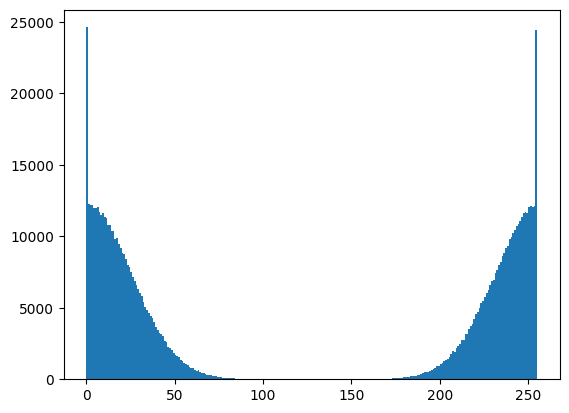

In [3]:
img = Image.open("/is/sg2/mkaut/ma-thesis/testimg.png")
img_shape = np.array(img).shape
gaussian_std = 0.1


g_noise = np.random.normal(0, gaussian_std, img_shape) * 255
g_noise = g_noise.astype(np.uint8)
# plot histogrma of noise
plt.hist(g_noise.flatten(), bins=255)
plt.show()

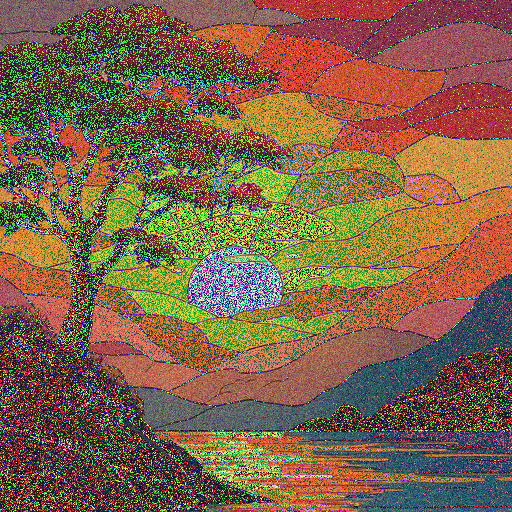

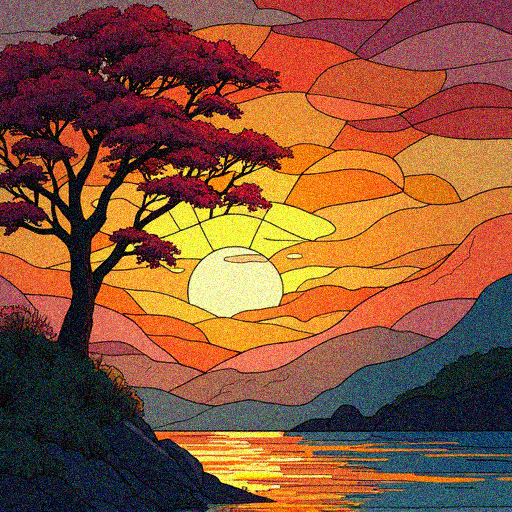

In [4]:
gaussian_std = 0.1
# old, wrong way
g_noise = np.random.normal(0, gaussian_std, img_shape) * 255
g_noise = g_noise.astype(np.uint8)
img_wrongnoise = Image.fromarray(np.clip(np.array(img) + g_noise, 0, 255))
display(img_wrongnoise)

# new, correct way
g_noise = np.random.normal(0, gaussian_std, img_shape) * 255
g_noise = g_noise#.astype(np.uint8)
img_fixednoise = Image.fromarray(np.clip(np.array(img) + g_noise, 0, 255).astype(np.uint8))
display(img_fixednoise)

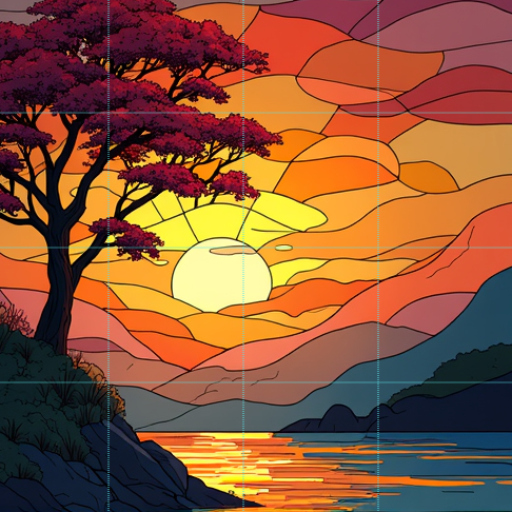

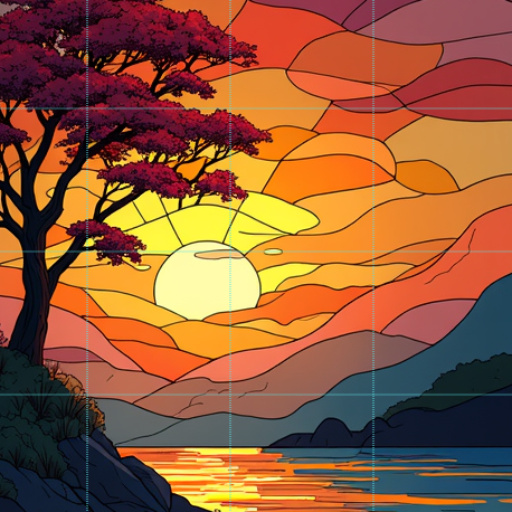

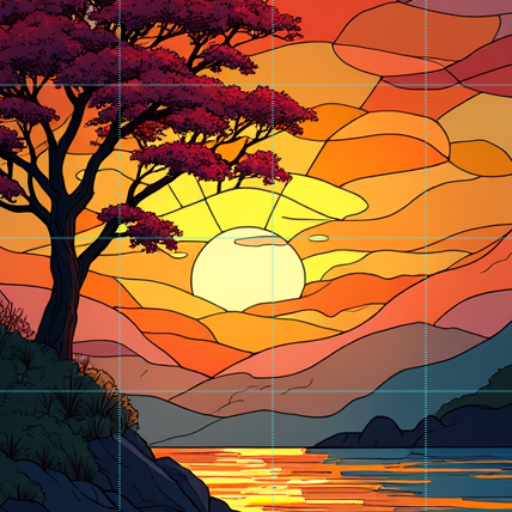

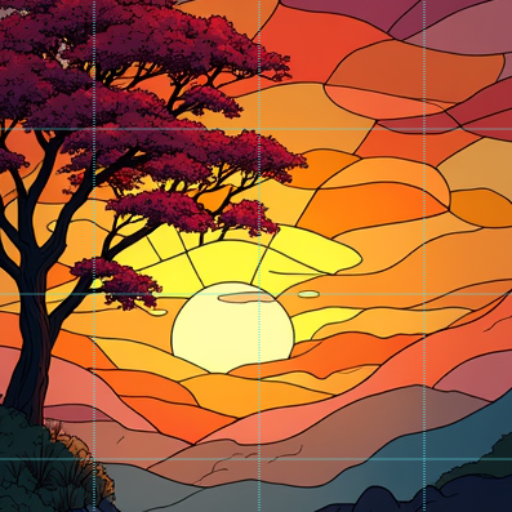

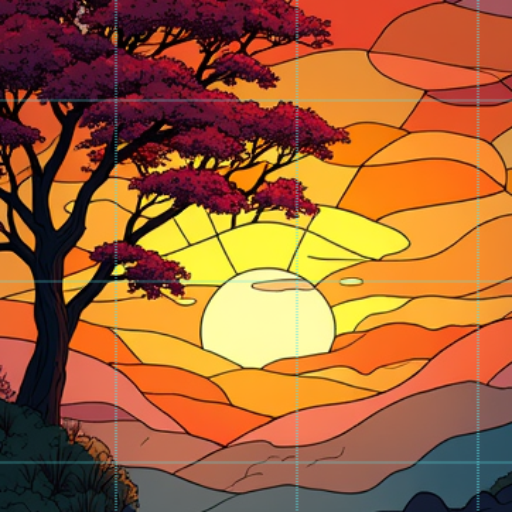

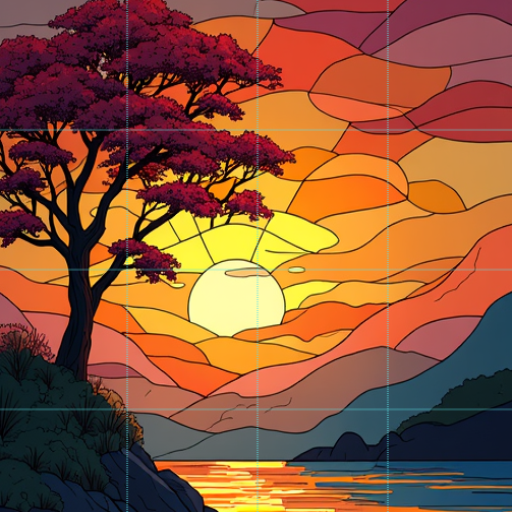

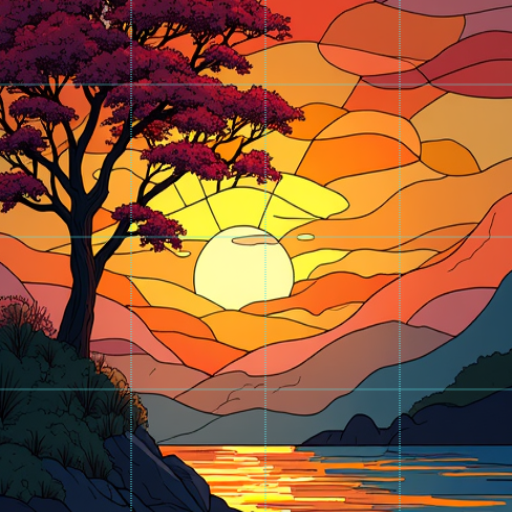

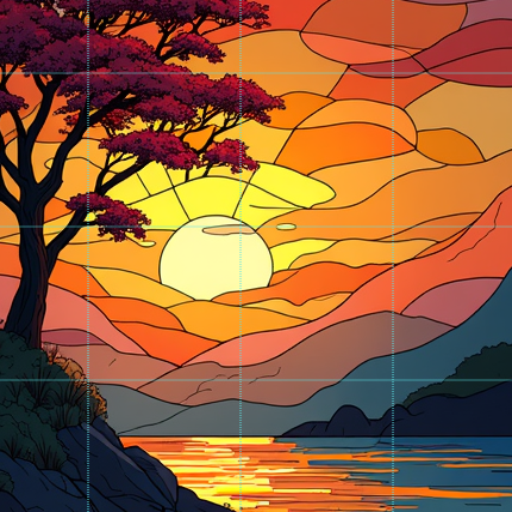

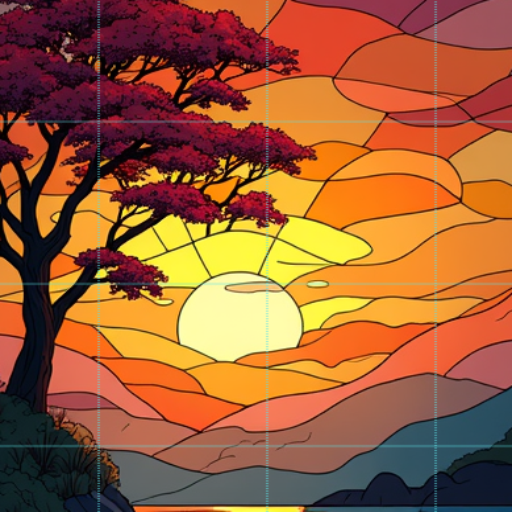

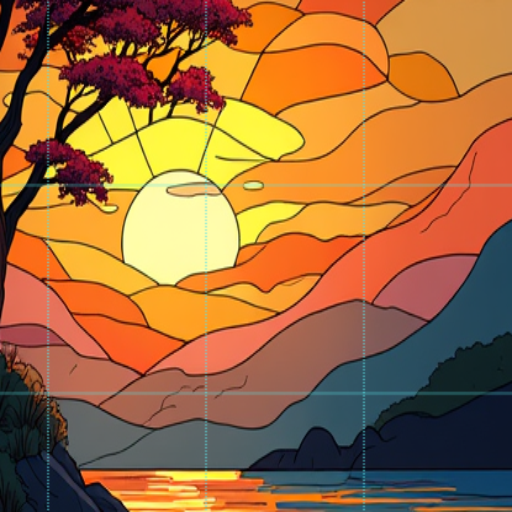

In [8]:

img = Image.open("/is/sg2/mkaut/ma-thesis/testimg_grid.png")
img_shape = np.array(img).shape

# first only crop, no other ratio
crops = [0.9, 0.8, 0.7, 0.6, 0.5]
for i, val in enumerate(crops):
    scale = (val, val)  # exact val% area
    ratio = (1.0, 1.0)  # but always square
    img_crop = transforms.RandomResizedCrop(
        img.size, 
        scale=scale,
        ratio=ratio,
        interpolation=InterpolationMode.BILINEAR
    )(img)
    display(img_crop)

# now only ratio, no other crop
ratios = [0.9, 0.8, 0.7, 0.6, 0.5]
for i, val in enumerate(ratios):
    scale = (val, val)  # exact val% area
    ratio = (1 - val, 1 + val)  # (0.75, 1.25)
    img_ratio = transforms.RandomResizedCrop(
        img.size, 
        scale=scale,
        ratio=ratio,
        interpolation=InterpolationMode.BILINEAR
    )(img)
    display(img_ratio)



In [ ]:
# plot all the augmented images, 6 attacks woth 5 variations each
# 30 images in total
# attacks per row, variations per column



img = Image.open("/is/sg2/mkaut/ma-thesis/testimg.png")
img_shape = np.array(img).shape

fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(6, 5, wspace=0.1, hspace=0.2)

noise_vals = [0.02, 0.04, 0.06, 0.08, 0.1]
for i, val in enumerate(noise_vals):
    g_noise = np.random.normal(0, val, img_shape) * 255 
    img_noise = Image.fromarray(np.clip(np.array(img) + g_noise, 0, 255).astype(np.uint8))
    ax = plt.subplot(gs[i])
    ax.imshow(img_noise)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"noise {val}")

brightness_vals = [1.2, 1.4, 1.6, 1.8, 2]
for i, val in enumerate(brightness_vals):
    img_bright = transforms.ColorJitter(brightness=(val, val))(img)
    ax = plt.subplot(gs[i+5])
    ax.imshow(img_bright)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"bright {val}")

blur_vals = [1, 2, 3, 4, 5]
for i, val in enumerate(blur_vals):
    img_blur = img.filter(ImageFilter.GaussianBlur(radius=val))
    ax = plt.subplot(gs[i+10])
    ax.imshow(img_blur)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"blur {val}")
    
r_degrees = [1, 2, 3, 4, 5]
for i, val in enumerate(r_degrees):
    img_rot = transforms.RandomRotation((val, val), interpolation=InterpolationMode.BICUBIC)(img)
    ax = plt.subplot(gs[i+15])
    ax.imshow(img_rot)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"rot {val}")

crop_scales = [0.9, 0.8, 0.7, 0.6, 0.5]
for i, val in enumerate(crop_scales):
    scale = (val, val)  # exact 25% area
    ratio = (1 - val, 1 + val)  # (0.75, 1.25)
    img_crop = transforms.RandomResizedCrop(
        img.size, 
        scale=scale,
        ratio=ratio,
        interpolation=InterpolationMode.BILINEAR
    )(img)
    ax = plt.subplot(gs[i+20])
    ax.imshow(img_crop)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"crop {val}")

jpeg_qs = [90, 70, 50, 30, 10]
for i, val in enumerate(jpeg_qs):
    img.save("testimg.jpg", quality=val)
    img_jpeg = Image.open("testimg.jpg")
    ax = plt.subplot(gs[i+25])
    ax.imshow(img_jpeg)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"jpeg {val}")

plt.savefig("attack_examples.png", dpi=300)


In [ ]:
from diffusers import FluxPipeline, DiffusionPipeline, FluxImg2ImgPipeline


pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", 
                                    torch_dtype=torch.bfloat16,
                                    cache_dir=HF_CACHE_DIR)
pipe.to("cuda")


In [ ]:
from diffusers import FluxPipeline, DiffusionPipeline, FluxImg2ImgPipeline


pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", 
                                    torch_dtype=torch.bfloat16,
                                    cache_dir=HF_CACHE_DIR)
pipe.to("cuda")

In [ ]:
# FLUX VAE
# pipe.vae.config.scaling_factor = 0.3611
# pipe.vae.config.shift_factor = 0.1159

In [ ]:
from diffusers import StableDiffusionPipeline,DiffusionPipeline, StableDiffusionImg2ImgPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base",
                                                  cache_dir=HF_CACHE_DIR)
pipe.to("cuda")

In [ ]:

prompts_single = "A young female speaker with short wavy brown hair in a white blouse at a podium facing a huge audience of a diverse group of young adults dressed casually, sitting in rows of chairs, in a lecture hall with white walls, photo over her shoulder, extra bright spotlight lighting on her, microphone on podium, clothing colorpalette red, orange, blue creating a professional and academic atmosphere."

img = Image.open("/is/sg2/mkaut/ma-thesis/experiments/rid/flux/mjprompts/num_10_fpr_0.01_cfg_3.0_wmch_16/encoded_imgs/data/nowm/5.png")

resolution = 512 
seed = 5356 # 13 best

seed_everything(seed) # local function to set all available seeds
#generators = [torch.Generator("cuda").manual_seed(s) for s in range(len(prompts))]

images = pipe(prompts_single, 
            #generator=generators,
            #image=img, strength=0.9999,
            num_inference_steps=50, 
            guidance_scale=3.0,
            height=resolution,
            width=resolution,
            ).images

display(images[0])


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(int(np.ceil(np.sqrt(len(prompts)))), int(np.ceil(np.sqrt(len(prompts)))), figsize=(20, 20))
for i in range(len(prompts)):
    ax[i // int(np.ceil(np.sqrt(len(prompts))) ), i % int(np.ceil(np.sqrt(len(prompts))) )].imshow(images[i])
    ax[i // int(np.ceil(np.sqrt(len(prompts))) ), i % int(np.ceil(np.sqrt(len(prompts))) )].axis("off")


plt.show()
